In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [4]:
# get data
# hsx
df = pd.read_csv('CafeF.HSX.Upto29.03.2019.csv')
# vn30 ky 1 2019
frames = [df[df['<Ticker>']== 'CMG']]
data = pd.concat(frames)

In [5]:
data.set_index('<DTYYYYMMDD>', inplace = True)
data.drop(['<Ticker>'], inplace=True, axis = 1)
data.index = pd.to_datetime(data.index.astype(str), format = '%Y%m%d')
data = data.sort_index()
data['adv20'] = data['<Volume>']/(data['<Volume>'].shift(-1).rolling(20).mean())
data.ffill()
data.head()

,<Open>,<High>,<Low>,<Close>,<Volume>,adv20
<DTYYYYMMDD>,,,,,,
2010-01-22,24.9795,24.9795,20.3405,24.9803,117370,NaN
2010-01-25,23.7662,23.7662,23.7662,23.7669,5280,NaN
2010-01-26,22.6243,22.6243,22.6243,22.6250,32860,NaN
2010-01-27,21.5537,21.5537,21.5537,21.5544,7740,NaN
2010-01-28,20.4832,20.4832,20.4832,20.4838,2490,NaN


In [4]:
# data['diff'] = data['<Close>'] - data['<Close>'].shift(1)
# data.dropna(inplace=True)

In [7]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

In [8]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    print(len(train_data), len(test_data))
    return train_data, test_data

In [53]:
# target_col = 'diff'
# train, test = train_test_split(data, test_size=0.1)
# line_plot(train[target_col], test[target_col], 'training', 'test', title='CMG')

In [9]:
from sklearn.preprocessing import MinMaxScaler
values = data['<Close>'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [10]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

1592 683


In [11]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [12]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

1591
682


In [13]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:
values = data[['<Close>'] + ['<Volume>'] + ['<Open>'] + ['<High>'] + ['<Low>'] + ['adv20']].values
values = values.astype('float32')

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [17]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
20,0.388807,0.004383,0.368155,0.380645,0.398203,0.023157,0.370970,0.018593,0.366482,0.370672,0.376392,0.097140
21,0.370970,0.018593,0.366482,0.370672,0.376392,0.097140,0.372753,0.008308,0.349753,0.357372,0.380026,0.044036
22,0.372753,0.008308,0.349753,0.357372,0.380026,0.044036,0.379890,0.019374,0.358174,0.354104,0.374634,0.100534
23,0.379890,0.019374,0.358174,0.354104,0.374634,0.100534,0.379890,0.013631,0.358174,0.354104,0.380088,0.069159
24,0.379890,0.013631,0.358174,0.354104,0.380088,0.069159,0.379890,0.010105,0.364866,0.360754,0.370997,0.050665


In [18]:
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
20   0.388807   0.004383   0.368155   0.380645   0.398203   0.023157  0.370970
21   0.370970   0.018593   0.366482   0.370672   0.376392   0.097140  0.372753
22   0.372753   0.008308   0.349753   0.357372   0.380026   0.044036  0.379890
23   0.379890   0.019374   0.358174   0.354104   0.374634   0.100534  0.379890
24   0.379890   0.013631   0.358174   0.354104   0.380088   0.069159  0.379890


In [19]:
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1577, 1, 6) (1577,) (677, 1, 6) (677,)


In [20]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


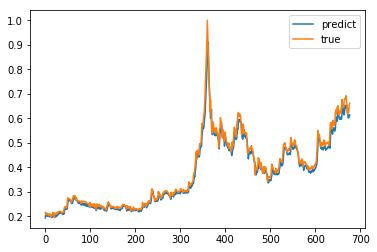

In [21]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [22]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [23]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.939


In [90]:
# testY_inverse = data['<Close>'][1592:]
# yhat_inverse = data['<Close>'][1591:2273] + inv_yhat
# # testY_inverse = y + inv_y

In [31]:
# only close
now_yhat = inv_yhat[1:]
yes_yhat = inv_yhat[:-1]
now = inv_y[1:]
yes = inv_y[:-1]
print(np.sum((now_yhat -yes_yhat )*(now - yes) > 0)/683)
from sklearn.metrics import r2_score
print(r2_score(inv_y, inv_yhat))

0.44363103953147875
0.9854959245940886


In [24]:
# only close
now_yhat = inv_yhat[1:]
yes_yhat = inv_yhat[:-1]
now = inv_y[1:]
yes = inv_y[:-1]
print(np.sum((now_yhat -yes_yhat )*(now - yes) > 0)/683)
from sklearn.metrics import r2_score
print(r2_score(inv_y, inv_yhat))

0.45095168374816985
0.9758821262094767
